# Example-based verifications

In [1]:
# general tools
import os
import sys
import h5py
import numpy as np
from glob import glob
from datetime import datetime, timedelta

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    lon_CCPA = h5io['lon_CCPA'][...]
    lat_CCPA = h5io['lat_CCPA'][...]
    land_mask_CCPA = h5io['land_mask_CCPA'][...]
land_mask_CCPA = land_mask_CCPA == 1.0
ocean_mask_CCPA = land_mask_CCPA == 0.0

In [6]:
with h5py.File(camp_dir+'CCPA/CCPA_CDFs_lead_2002_2019.hdf', 'r') as h5io:
    CCPA_CDFs = h5io['CCPA_CDFs_lead'][...]

In [7]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

plt.rcParams['hatch.color'] = 'k'

In [8]:
cmap_pct, A = gu.precip_cmap()
# cmap_pct = cmaps.precip2_17lev

In [9]:
example = np.load(result_dir+'example_20210101_f48_re.npy', allow_pickle=True)[()]

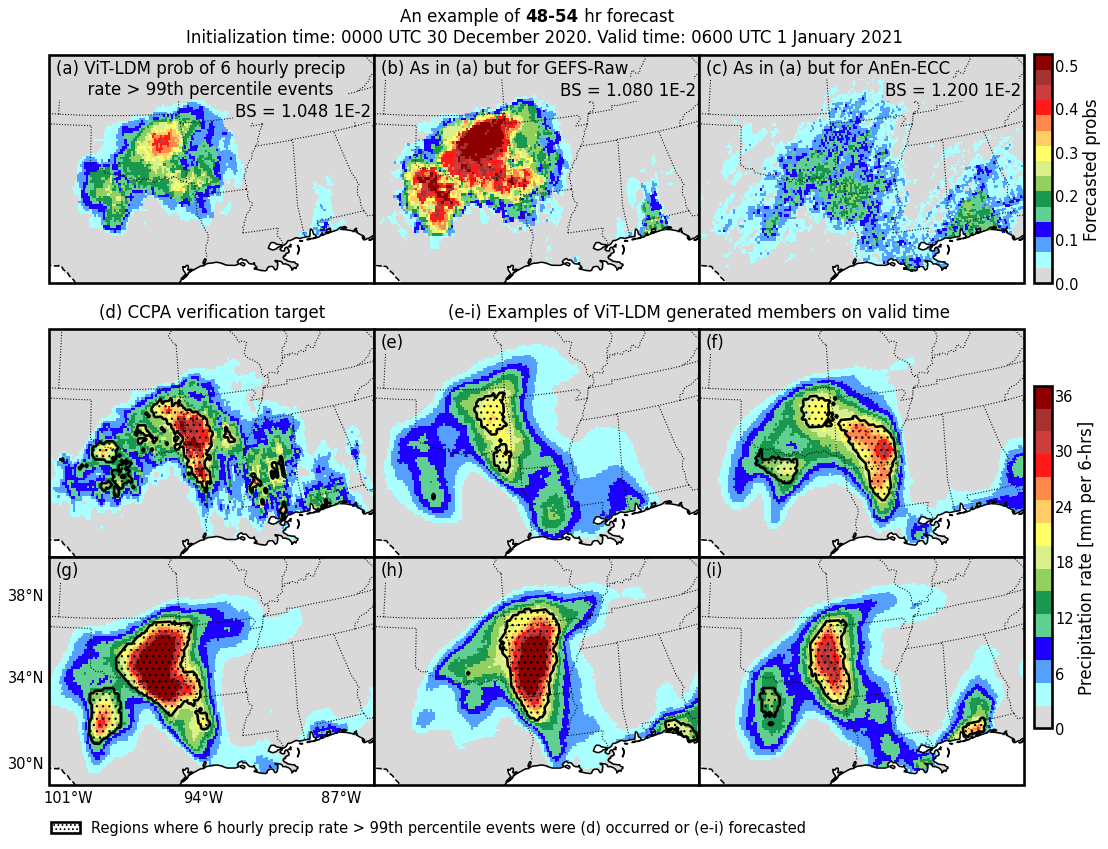

In [10]:
vmin = 0
vmax = 37
q_ = CCPA_CDFs[99, 8, ...]

titles = ['(a) ViT-LDM prob of 6 hourly precip\n      rate > 99th percentile events',  
          '(b) As in (a) but for GEFS-Raw', 
          '(c) As in (a) but for AnEn-ECC',
          '(d) CCPA verification target', '(e)', '(f)', '(g)', '(h)', '(i)']

edge = [-102, -85, 29, 38.75]
proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

fig = plt.figure(figsize=(13, 9.75), dpi=dpi_) #, dpi=dpi_
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 0.2, 1, 1], width_ratios=[1, 1, 1])
proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

AX = []
for i in [0, 2, 3]:
    for j in [0, 1, 2]:
        ax = plt.subplot(gs[i, j], projection=proj_)
        AX.append(ax)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

for i, ax in enumerate(AX):
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    if i == 6:
        GL.left_labels = True
        GL.bottom_labels = True
    else:
        GL.left_labels = None
        GL.bottom_labels = None
        
    GL.xlocator = mticker.FixedLocator([-101, -94, -87])
    GL.ylocator = mticker.FixedLocator([30, 34, 38])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=3)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=3)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.0, zorder=3)
    ax.spines['geo'].set_linewidth(2.5)
    if i == 3:
        handle = ax.text(0.5, 1.0325, titles[i], ha='center', va='bottom', fontsize=16, transform=ax.transAxes)       
    else:
        handle = ax.text(0.02, 0.98, titles[i], ha='left', va='top', fontsize=16, transform=ax.transAxes)
        handle.set_bbox(dict(facecolor='0.85', pad=2, linewidth=0, zorder=7))
    

CS_prob = AX[0].pcolormesh(lon_CCPA, lat_CCPA, example['LDM_p99'], vmin=0, vmax=0.525, 
                 cmap=cmap_pct, transform=ccrs.PlateCarree())

AX[1].pcolormesh(lon_CCPA, lat_CCPA, example['GEFS_RAW_p99'], vmin=0, vmax=0.525, 
                 cmap=cmap_pct, transform=ccrs.PlateCarree())

AX[2].pcolormesh(lon_CCPA, lat_CCPA, example['AnEn_p99'], vmin=0, vmax=0.525, 
                 cmap=cmap_pct, transform=ccrs.PlateCarree())

iens = [0, 1, 2, 3, 4,]

CS = AX[3].pcolormesh(lon_CCPA, lat_CCPA, example['CCPA'], vmin=vmin, vmax=vmax, 
                      cmap=cmap_pct, transform=ccrs.PlateCarree())

AX[3].contourf(lon_CCPA, lat_CCPA, example['CCPA_p99'], hatches=(None, '..'), 
               colors=('none',), transform=ccrs.PlateCarree())
AX[3].contour(lon_CCPA, lat_CCPA, example['CCPA_p99'], colors=('k'), 
              linewidths=(2.5,), linestyles=('-'), transform=ccrs.PlateCarree())

for i, iax in enumerate([4, 5, 6, 7, 8]):
    AX[iax].pcolormesh(lon_CCPA, lat_CCPA, example['LDM'][iens[i], ...], vmin=vmin, vmax=vmax, 
                       cmap=cmap_pct, transform=ccrs.PlateCarree())
    AX[iax].contourf(lon_CCPA, lat_CCPA, example['LDM'][iens[i], ...]>q_, hatches=(None, '..'), 
                   colors=('none',), transform=ccrs.PlateCarree())
    AX[iax].contour(lon_CCPA, lat_CCPA, example['LDM'][iens[i], ...]>q_, colors=('k'), 
                  linewidths=(2.5,), linestyles=('-'), transform=ccrs.PlateCarree())

# mae_RAW = np.nanmean(np.abs(example['GEFS_mean'] - example['CCPA']))
# mae_LDM = np.nanmean(np.abs(example['LDM_mean'] - example['CCPA']))
# mae_AnEn = np.nanmean(np.abs(example['AnEn_mean'] - example['CCPA']))

# CRPS_RAW, _, _ = vu.CRPS_2d(example['CCPA'][None, ...], example['GEFS_RAW'][None, ...], land_mask_CCPA)
# CRPS_AnEn, _, _ = vu.CRPS_2d(example['CCPA'][None, ...], example['AnEn'][None, ...], land_mask_CCPA)
# CRPS_LDM, _, _ = vu.CRPS_2d(example['CCPA'][None, ...], example['LDM'][None, ...], land_mask_CCPA)

# crps_RAW = np.nanmean(CRPS_RAW)
# crps_LDM = np.nanmean(CRPS_LDM)
# crps_AnEn = np.nanmean(CRPS_AnEn)

bs_RAW = np.nanmean((example['GEFS_RAW_p99'] - example['CCPA_p99'])**2)
bs_AnEn = np.nanmean((example['AnEn_p99'] - example['CCPA_p99'])**2)
bs_LDM = np.nanmean((example['LDM_p99'] - example['CCPA_p99'])**2)

handle = AX[0].text(0.99, 0.711, 'BS = {:.3f} 1E-2'.format(1e2*bs_LDM), 
                    ha='right', va='bottom', fontsize=16, transform=AX[0].transAxes)
handle.set_bbox(dict(facecolor='0.85', pad=2, linewidth=0, zorder=7))

handle = AX[1].text(0.99, 0.803, 'BS = {:.3f} 1E-2'.format(1e2*bs_RAW), 
                    ha='right', va='bottom', fontsize=16, transform=AX[1].transAxes)
handle.set_bbox(dict(facecolor='0.85', pad=2, linewidth=0, zorder=7))

handle = AX[2].text(0.99, 0.803, 'BS = {:.3f} 1E-2'.format(1e2*bs_AnEn), 
                    ha='right', va='bottom', fontsize=16, transform=AX[2].transAxes)
handle.set_bbox(dict(facecolor='0.85', pad=2, linewidth=0, zorder=7))

ax_base = fig.add_axes([1.0+0.01, 2.2/3.2, 0.06, 1/3.2])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='100%', width='30%', borderpad=0, loc=2)
CBar = plt.colorbar(CS_prob, orientation='vertical', cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_ylabel('Forecasted probs', fontsize=16)

ax_base = fig.add_axes([1.0+0.01, 0.25/3.2, 0.06, 1.5/3.2])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='100%', width='30%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='vertical', ticks=[0, 6, 12, 18, 24, 30, 36], cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_ylabel('Precipitation rate [mm per 6-hrs]', fontsize=16)

ax_all = fig.add_axes([0.5-(0.5*0.28), 1.04, 0.28, 0.025])
ax_all.set_axis_off()
gu.string_partial_format(fig, ax_all, 0.0, 1.0, 'left', 'top', 
                 ['An example of ', '48-54', ' hr forecast'],
                 ['k',]*3, [16,]*3, ['normal', 'bold', 'normal']);

ax_mid = fig.add_axes([2/3-(0.5*0.515), 0.64, 0.515, 0.02])
ax_mid.set_axis_off()
gu.string_partial_format(fig, ax_mid, 0.0, 1.0, 'left', 'top', 
                 ['(e-i) Examples of ViT-LDM generated members on valid time',],
                 ['k',]*4, [16,]*4, ['normal', 'normal', 'normal']);

ax_words1 = fig.add_axes([0.5-(0.5*0.72), 1.01, 0.72, 0.025])
ax_words1.text(0, 1, 
               'Initialization time: 0000 UTC 30 December 2020. Valid time: 0600 UTC 1 January 2021', 
               ha='left', va='top', fontsize=16, transform=ax_words1.transAxes);
ax_words1.set_axis_off()

handle_legneds = []
handle_legneds.append(patches.Patch(facecolor='w', edgecolor='k', linewidth=2.5, hatch='...', label=''))

ax_lg = fig.add_axes([0.0, -0.07, 0.79, 0.04])
ax_lg.set_axis_off()
LG = ax_lg.legend(handle_legneds, 
                  ['Regions where 6 hourly precip rate > 99th percentile events were (d) occurred or (e-i) forecasted'], 
                  bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}); gu.legend_format(LG)

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig6_example.png', format='png', **fig_keys)

In [12]:
## Old horizontal colorbar
# ax_base = fig.add_axes([1/3+1/12, -0.09, 1/2, 0.07])
# [j.set_linewidth(0.0) for j in ax_base.spines.values()]
# ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
#                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
# cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
# CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 6, 12, 18, 24, 30, 36], cax=cax)
# CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
# CBar.outline.set_linewidth(2.5)
# ax_base.text(0.5, 0, '[mm per 6-hrs]', ha='center', 
#              va='bottom', fontsize=14, transform=ax_base.transAxes)

### Old histogram version

In [ ]:
example = np.load(result_dir+'example_20210101_06h_re.npy', allow_pickle=True)[()]
bins = np.linspace(0, 1, 20)
bin_plot = np.linspace(bins[0]+0.5*(bins[1]-bins[0]), bins[18]+0.5*(bins[19]-bins[18]), 19)

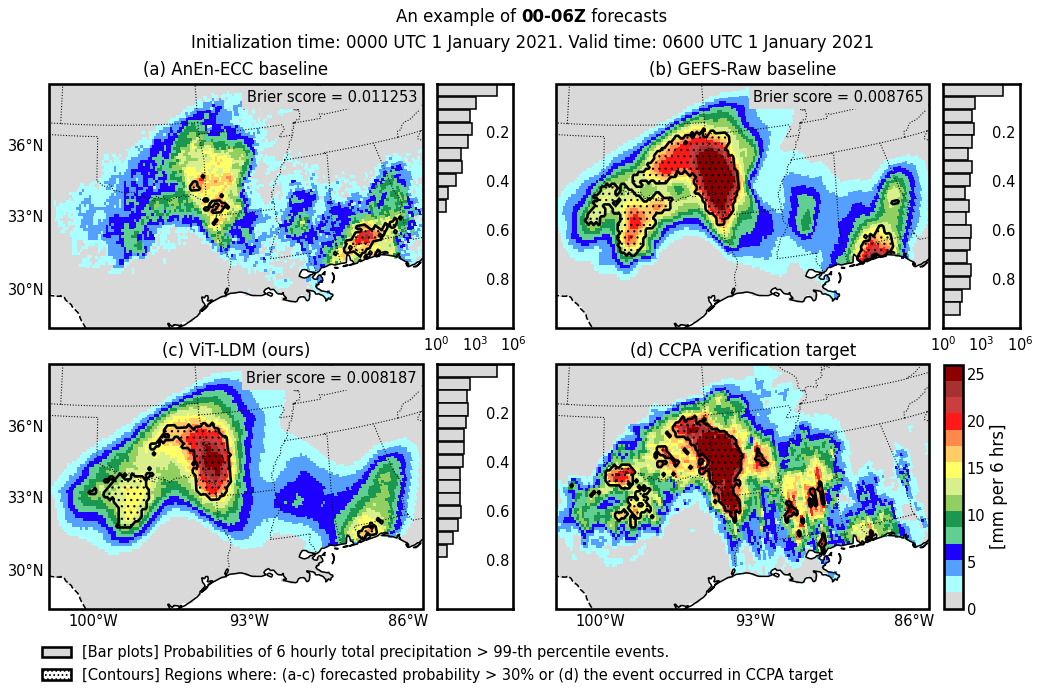

In [9]:
titles = ['(a) AnEn-ECC baseline', '(b) GEFS-Raw baseline', '(c) ViT-LDM (ours)', '(d) CCPA verification target']
thres = 0.3 # contour of the prob thres

edge = [-102, -85, 28.5, 37.5]
proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

fig = plt.figure(figsize=(13, 7.0), dpi=dpi_) #, dpi=dpi_
gs = gridspec.GridSpec(3, 7, height_ratios=[1, 0.15, 1], width_ratios=[1, 0.025, 0.2, 0.1, 1, 0.025, 0.2])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

ax0 = plt.subplot(gs[0, 0], projection=proj_)
ax1 = plt.subplot(gs[0, 4], projection=proj_)
ax2 = plt.subplot(gs[2, 0], projection=proj_)
ax3 = plt.subplot(gs[2, 4], projection=proj_)
AX = [ax0, ax1, ax2, ax3]

AX_hist = []
for j in [2, 6]:
    AX_hist.append(plt.subplot(gs[0, j]))
AX_hist.append(plt.subplot(gs[2, 2]))
AX_hist = AX_hist

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

for i, ax in enumerate(AX_hist):
    ax = gu.ax_decorate_box(ax)
    ax.set_ylim([1, 0])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_xlim([1e0, 1e6])
    ax.set_xticks([1e2, 1e4])
    ax.tick_params(axis='y', labelright=True, pad=-30)
    if i in [0, 1]:
        ax.tick_params(labelbottom=True)
    
for i, ax in enumerate(AX):
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    if i in [1, 3]:
        GL.left_labels = None
    if i in[0, 1]:
        GL.bottom_labels = None
    GL.xlocator = mticker.FixedLocator([-100, -93, -86])
    GL.ylocator = mticker.FixedLocator([30, 33, 36])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.0, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    
    ax.text(0.5, 1.02, titles[i], ha='center', va='bottom', fontsize=16, transform=ax.transAxes)
    
keys = ['AnEn_mean', 'RAW_mean', 'LDM_mean', 'CCPA']
keys_prob = ['AnEn_prob_99', 'RAW_prob_99', 'LDM_prob_99', 'CCPA_99']

for i, ax in enumerate(AX_hist):
    ax.barh(bin_plot, example[keys_prob[i]+'_hist'], height=0.05, facecolor='0.85', 
            edgecolor='k', linewidth=1.5, align='center')
    ax.set_xscale('log')

for i, ax in enumerate(AX):
    y_plot = example[keys[i]]
    CS = ax.pcolormesh(lon_CCPA, lat_CCPA, y_plot, vmin=0, vmax=26.0, 
                       cmap=cmap_pct, transform=ccrs.PlateCarree())

handle = []
for i, ax in enumerate(AX[:3]):
    y_prob = example[keys_prob[i]]
    y_prob_25 = y_prob >= thres

    bs_ = np.nanmean((y_prob-example['CCPA_99'])**2)
    handle.append(ax.text(0.985, 0.975, 'Brier score = {:03f}'.format(bs_), zorder=7,
                          ha='right', va='top', fontsize=14, transform=ax.transAxes))
    
    ax.contourf(lon_CCPA, lat_CCPA, y_prob_25, hatches=(None, '..'), 
                colors=('none',), transform=ccrs.PlateCarree())
    ax.contour(lon_CCPA, lat_CCPA, y_prob_25, colors=('k'), 
               linewidths=(2.5,), linestyles=('-'), transform=ccrs.PlateCarree())

for h in handle:
    h.set_bbox(dict(facecolor='0.85', linewidth=0, zorder=7))

ax3.contourf(lon_CCPA, lat_CCPA, example['CCPA_99'], hatches=(None, '..'), 
             colors=('none',), transform=ccrs.PlateCarree())
ax3.contour(lon_CCPA, lat_CCPA, example['CCPA_99'], colors=('k'), 
            linewidths=(2.5,), linestyles=('-'), transform=ccrs.PlateCarree())

ax_base = fig.add_axes([0.9225, 0.0, 0.065, 0.465])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='30%', height='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='vertical', cax=cax) #ticks=[0, 7, 14, 21, 28], 
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(1.0, 0.5, '[mm per 6 hrs]', ha='right', 
             va='center', rotation=90, fontsize=16, transform=ax_base.transAxes)

handle_legneds = []
handle_legneds.append(patches.Patch(facecolor='0.85', edgecolor='k', linewidth=2.5, label=''))
handle_legneds.append(patches.Patch(facecolor='w', edgecolor='k', linewidth=2.5, hatch='...', label=''))

ax_lg = fig.add_axes([0.0, -0.145, 0.8225, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handle_legneds, 
                  ['[Bar plots] Probabilities of 6 hourly total precipitation > 99th percentile events.', 
                   '[Contours] Regions where: (a-c) forecasted probability > 30% or (d) the event occurred in CCPA target'], 
                  bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}); gu.legend_format(LG)

ax_all = fig.add_axes([0.5-(0.5*0.28), 1.11, 0.28, 0.035])
ax_all.set_axis_off()

gu.string_partial_format(fig, ax_all, 0.0, 1.0, 'left', 'top', 
                 ['An example of ', '00-06Z', ' forecasts'],
                 ['k',]*3, [16,]*3, ['normal', 'bold', 'normal']);

ax_words1 = fig.add_axes([0.5-(0.5*0.7), 1.06, 0.7, 0.035])
ax_words1.text(0, 1, 
               'Initialization time: 0000 UTC 1 January 2021. Valid time: 0600 UTC 1 January 2021', 
               ha='left', va='top', fontsize=16, transform=ax_words1.transAxes);
ax_words1.set_axis_off()

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig_example.png', format='png', **fig_keys)

## Old no-histogram version

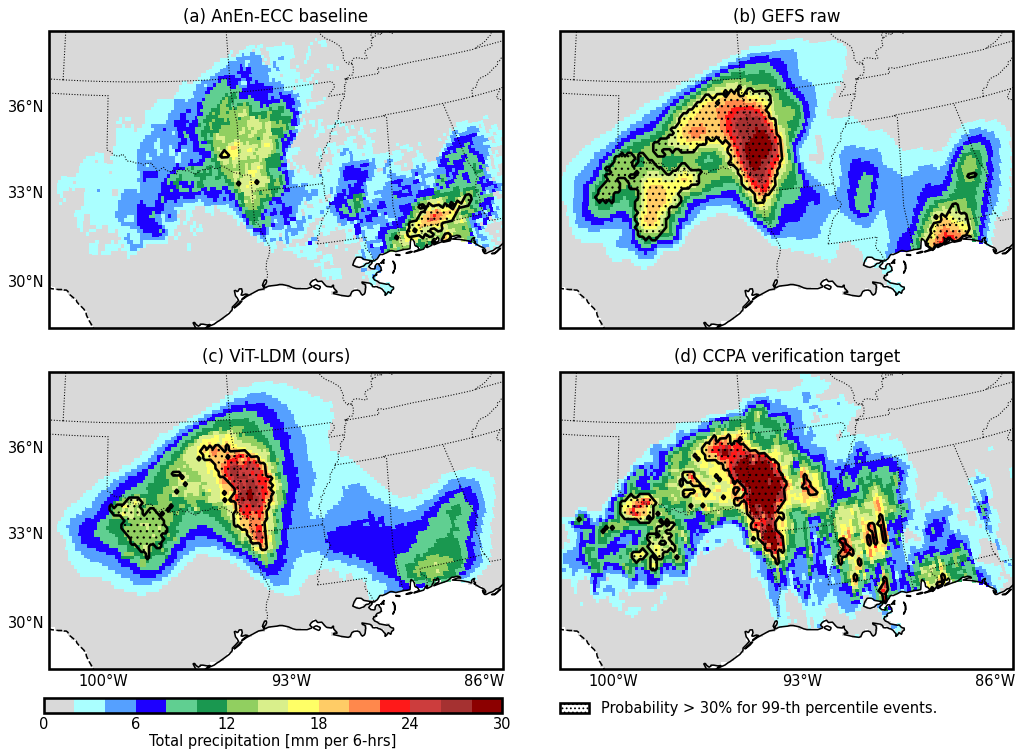

In [21]:
titles = ['(a) AnEn-ECC baseline', '(b) GEFS raw', '(c) ViT-LDM (ours)', '(d) CCPA verification target']

edge = [-102, -85, 28.5, 37.5]
proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

fig = plt.figure(figsize=(13, 8.5), dpi=dpi_) #, dpi=dpi_
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1,])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

ax0 = plt.subplot(gs[0, 0], projection=proj_)
ax1 = plt.subplot(gs[0, 1], projection=proj_)
ax2 = plt.subplot(gs[1, 0], projection=proj_)
ax3 = plt.subplot(gs[1, 1], projection=proj_)
AX = [ax0, ax1, ax2, ax3]

plt.subplots_adjust(0, 0, 1, 1, hspace=0.15, wspace=0.1)

for i, ax in enumerate(AX):
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    if i in [1, 3]:
        GL.left_labels = None
    if i in[0, 1]:
        GL.bottom_labels = None
    GL.xlocator = mticker.FixedLocator([-100, -93, -86])
    GL.ylocator = mticker.FixedLocator([30, 33, 36])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.0, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    
    ax.text(0.5, 1.02, titles[i], ha='center', va='bottom', fontsize=16, transform=ax.transAxes)
    
keys = ['AnEn_mean', 'RAW_mean', 'LDM_mean', 'CCPA']
keys_prob = ['AnEn_prob_99', 'RAW_prob_99', 'LDM_prob_99', 'CCPA_99']

for i, ax in enumerate(AX):
    y_plot = example[keys[i]]
    CS = ax.pcolormesh(lon_CCPA, lat_CCPA, y_plot, vmin=0, vmax=30.0, 
                       cmap=cmap_pct, transform=ccrs.PlateCarree())

for i, ax in enumerate(AX[:3]):
    y_prob = example[keys_prob[i]]
    y_prob_25 = y_prob >= 0.3
    ax.contourf(lon_CCPA, lat_CCPA, y_prob_25, hatches=(None, '..'), 
                colors=('none',), transform=ccrs.PlateCarree())
    ax.contour(lon_CCPA, lat_CCPA, y_prob_25, colors=('k'), 
               linewidths=(2.5,), linestyles=('-'), transform=ccrs.PlateCarree())

ax3.contourf(lon_CCPA, lat_CCPA, example['CCPA_99'], hatches=(None, '..'), 
             colors=('none',), transform=ccrs.PlateCarree())
ax3.contour(lon_CCPA, lat_CCPA, example['CCPA_99'], colors=('k'), 
            linewidths=(2.5,), linestyles=('-'), transform=ccrs.PlateCarree())

ax_base = fig.add_axes([0.0, -0.125, 0.47, 0.08])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 6, 12, 18, 24, 30], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 0, 'Total precipitation [mm per 6-hrs]', ha='center', 
             va='bottom', fontsize=14, transform=ax_base.transAxes)


handle_legneds = []
handle_legneds.append(patches.Patch(facecolor='w', edgecolor='k', linewidth=2.5, hatch='...', label=''))

ax_lg = fig.add_axes([0.53, -0.08, 0.4, 0.05])
ax_lg.set_axis_off()
LG = ax_lg.legend(handle_legneds, ['Probability > 30% for 99th percentile events.',], 
                  bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}); gu.legend_format(LG)